# Logs and Plots

- Plot the training loss and the validation perplexity scores for each checkpoint.

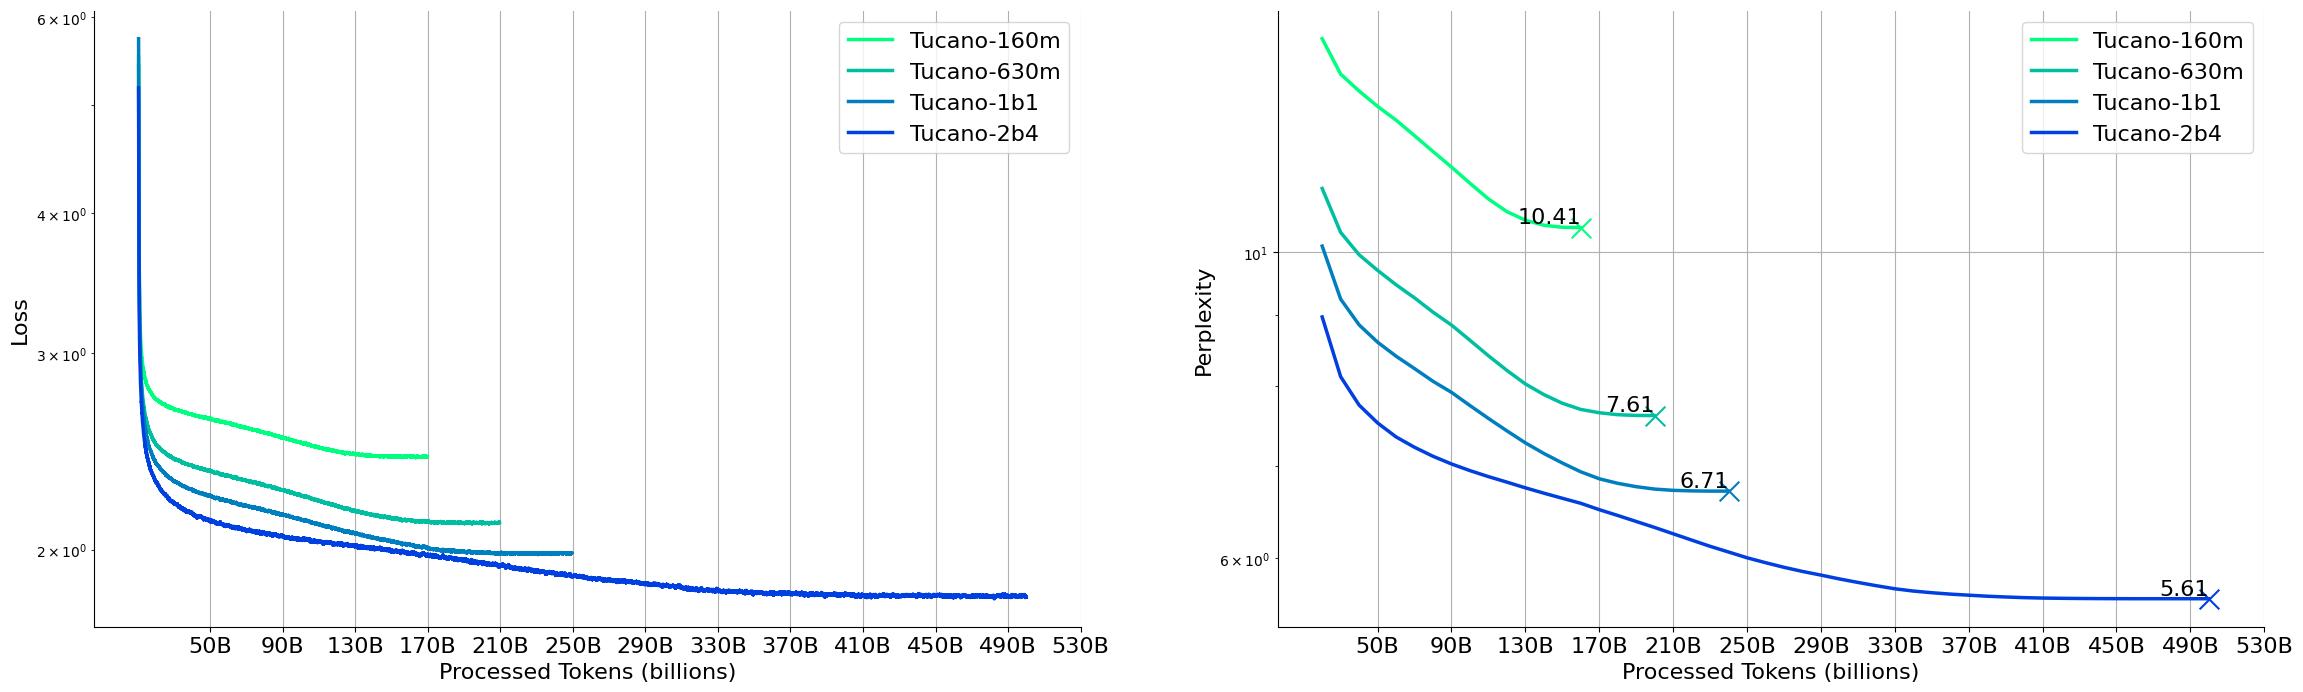

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(path_dict):
    dfs = {size: pd.read_parquet(path) for size, path in path_dict.items()}
    return dfs

def process_data(df_train, df_val, window_size=1000):
    for df in df_train.values():
        df['loss'] = df['loss'].rolling(window=window_size).mean()
    for df in df_val.values():
        df['perplexity'] = np.exp(df['loss'])

def plot_loss_and_perplexity(df_train, df_val, sizes, save):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 8))
    cmap = plt.get_cmap('winter_r')
    n_model = len(sizes)
    
    for i, size in enumerate(sizes):
        ax1.plot(df_train[size].step, df_train[size].loss, label=f'Tucano-{size}', 
                 color=cmap(i / n_model), linewidth=2.5)
    ax1.set_xlabel('Processed Tokens (billions)', fontsize=16)
    ax1.set_ylabel('Loss', fontsize=16)
    ax1.set_yscale('log')
    ax1.grid(True)
    ax1.legend(loc='upper right', fontsize=16)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    custom_ticks = [80000, 160000, 240000, 320000, 400000, 480000, 560000, 640000, 720000, 800000, 880000, 960000, 1040000]
    custom_tick_labels = [f"{math.floor((x / 1000000000) + 10)}B" for x in [500000 * x for x in custom_ticks]]
    ax1.set_xticks(custom_ticks)
    ax1.set_xticklabels(custom_tick_labels, fontsize=16)
    
    for i, size in enumerate(sizes):
        ax2.plot(df_val[size].step, df_val[size].perplexity, label=f'Tucano-{size}', 
                 color=cmap(i / n_model), linewidth=2.5)
        ax2.scatter(df_val[size].step.iloc[-1], df_val[size].perplexity.iloc[-1], 
                    color=cmap(i / n_model), marker='x', s=200)
        ax2.text(df_val[size].step.iloc[-1], df_val[size].perplexity.iloc[-1], 
                 f'{df_val[size].perplexity.iloc[-1]:.2f}', ha='right', va='bottom', fontsize=16)
    ax2.set_xlabel('Processed Tokens (billions)', fontsize=16)
    ax2.set_ylabel('Perplexity', fontsize=16)
    ax2.set_yscale('log')
    ax2.grid(True)
    ax2.legend(loc='upper right', fontsize=16)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax2.set_xticks(custom_ticks)
    ax2.set_xticklabels(custom_tick_labels, fontsize=16)

    if save:
        plt.savefig("../img/loss-perplexity.png", dpi=300, transparent=True)
        plt.savefig("../img/loss-perplexity.svg", format="svg", transparent=True)
    
    plt.show()

train_paths = {
    '160m': "./training-logs/training-logs-160m.parquet",
    '630m': "./training-logs/training-logs-630m.parquet",
    '1b1': "./training-logs/training-logs-1b1.parquet",
    '2b4': "./training-logs/training-logs-2b4.parquet"
}

val_paths = {
    '160m': "./training-logs/validation-logs-160m.parquet",
    '630m': "./training-logs/validation-logs-630m.parquet",
    '1b1': "./training-logs/validation-logs-1b1.parquet",
    '2b4': "./training-logs/validation-logs-2b4.parquet"
}

df_train = load_data(train_paths)
df_val = load_data(val_paths)
process_data(df_train, df_val)
plot_loss_and_perplexity(df_train, df_val, sizes=['160m', '630m', '1b1', '2b4'], save=True)


- Plot the evaluation results for all checkpoints.

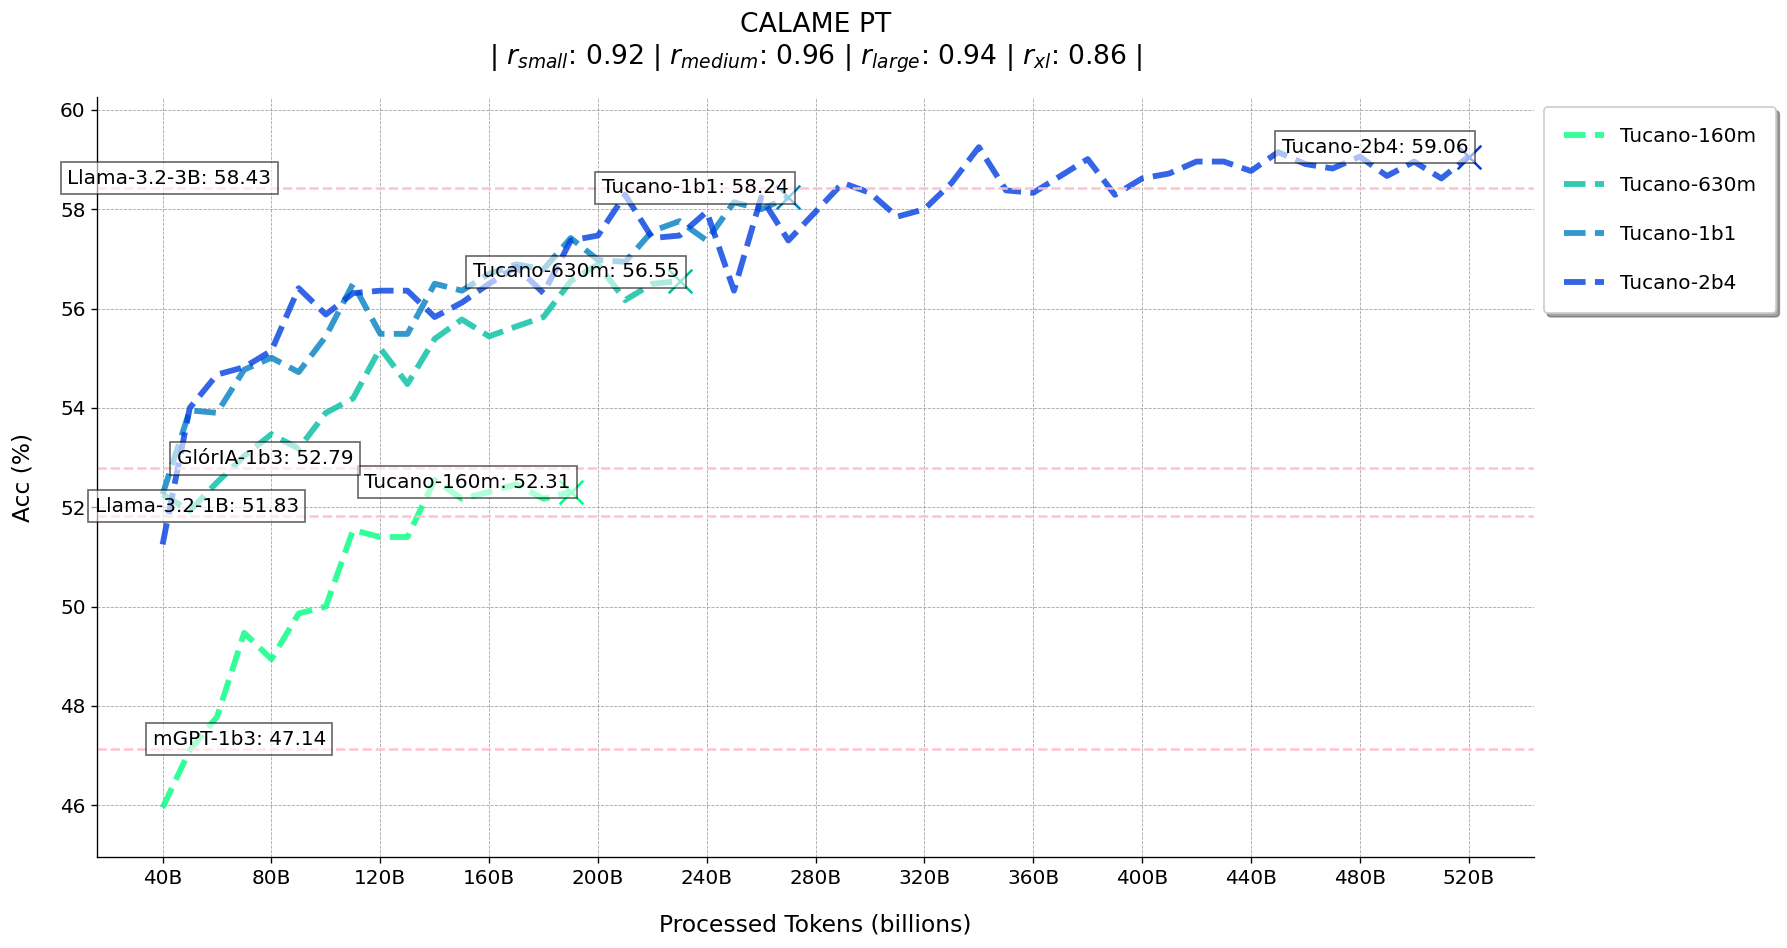

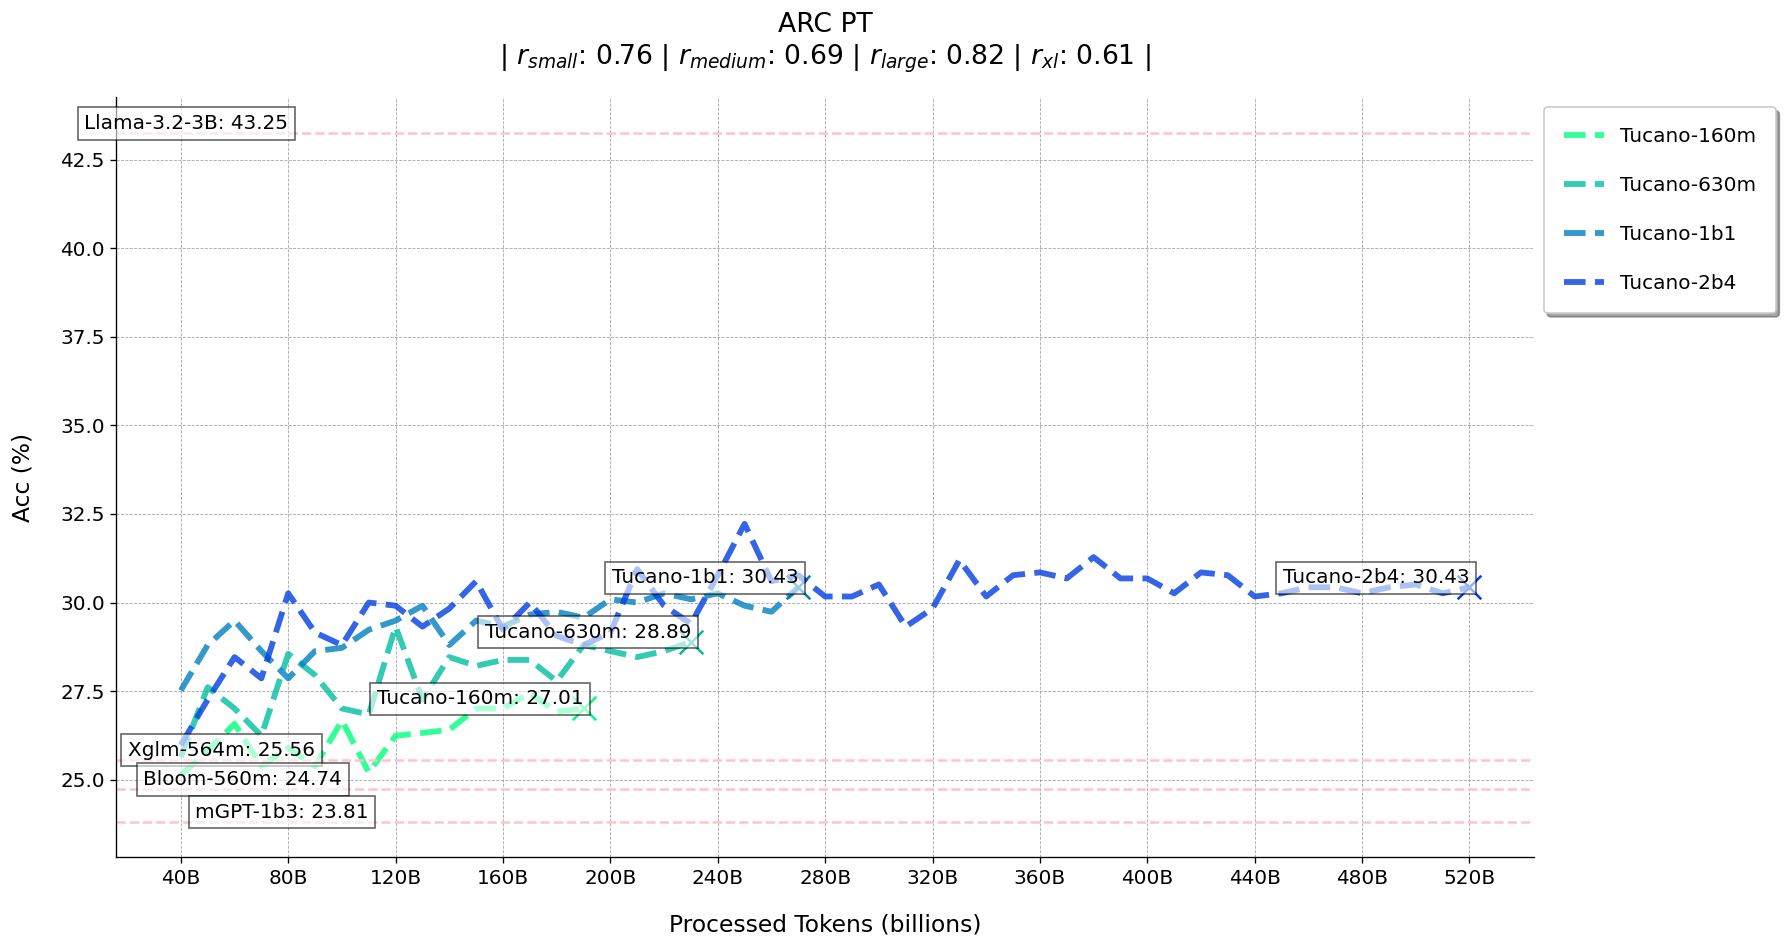

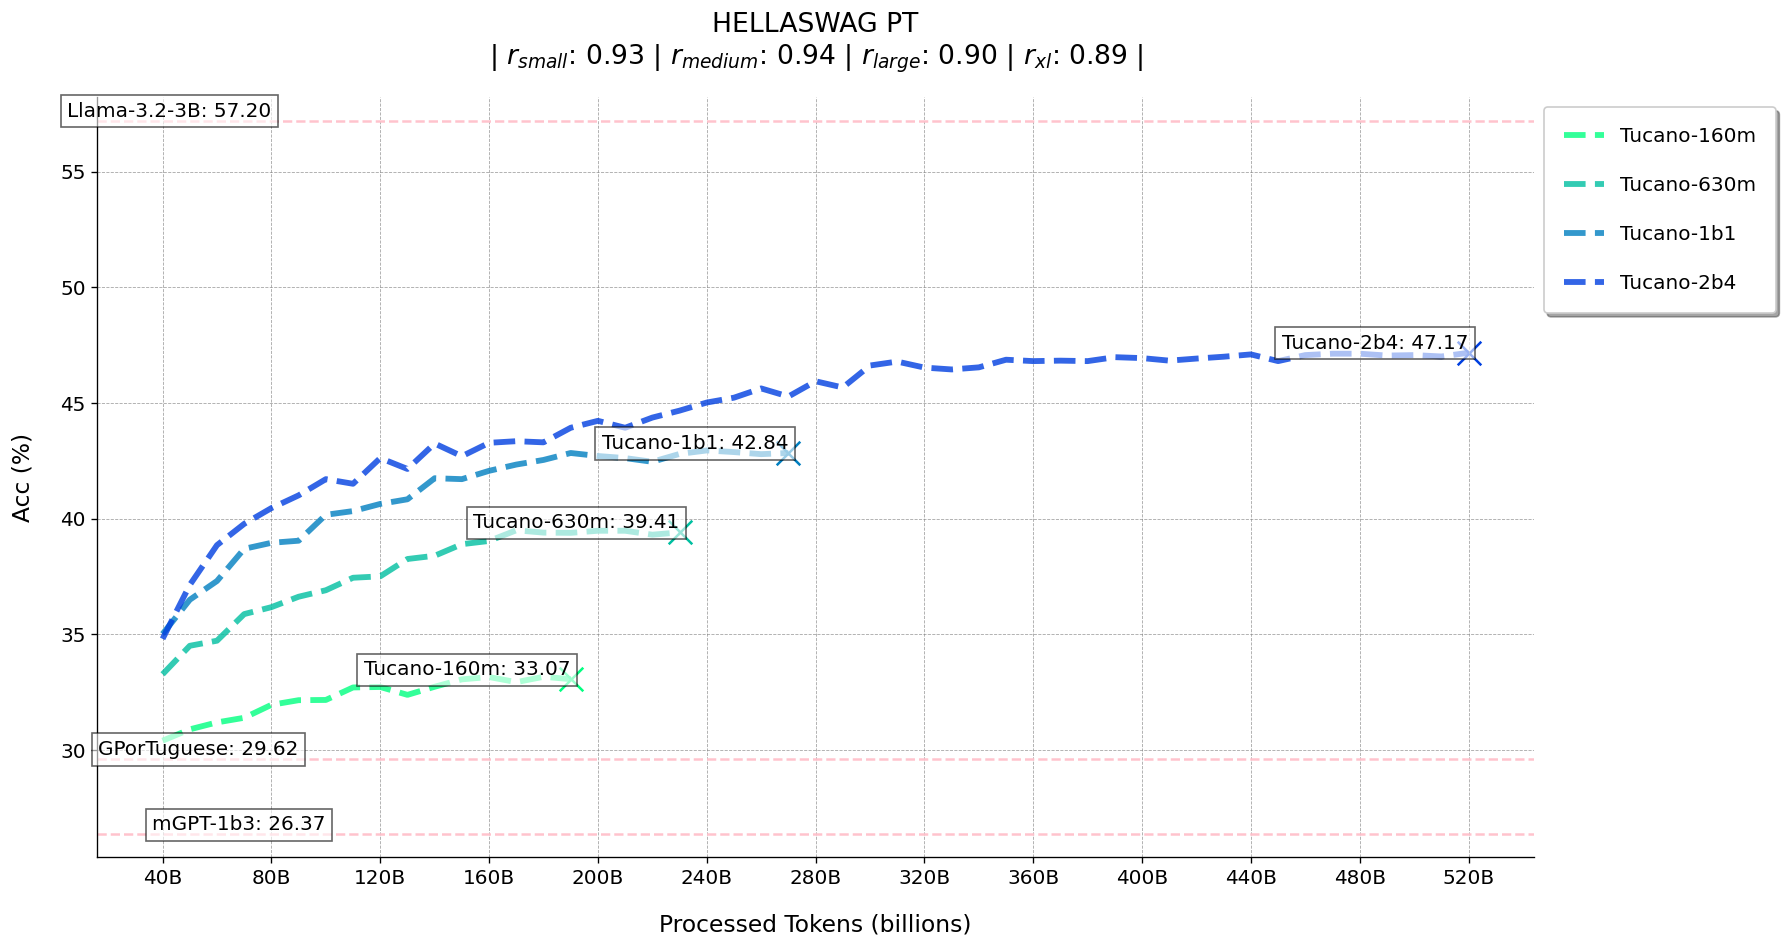

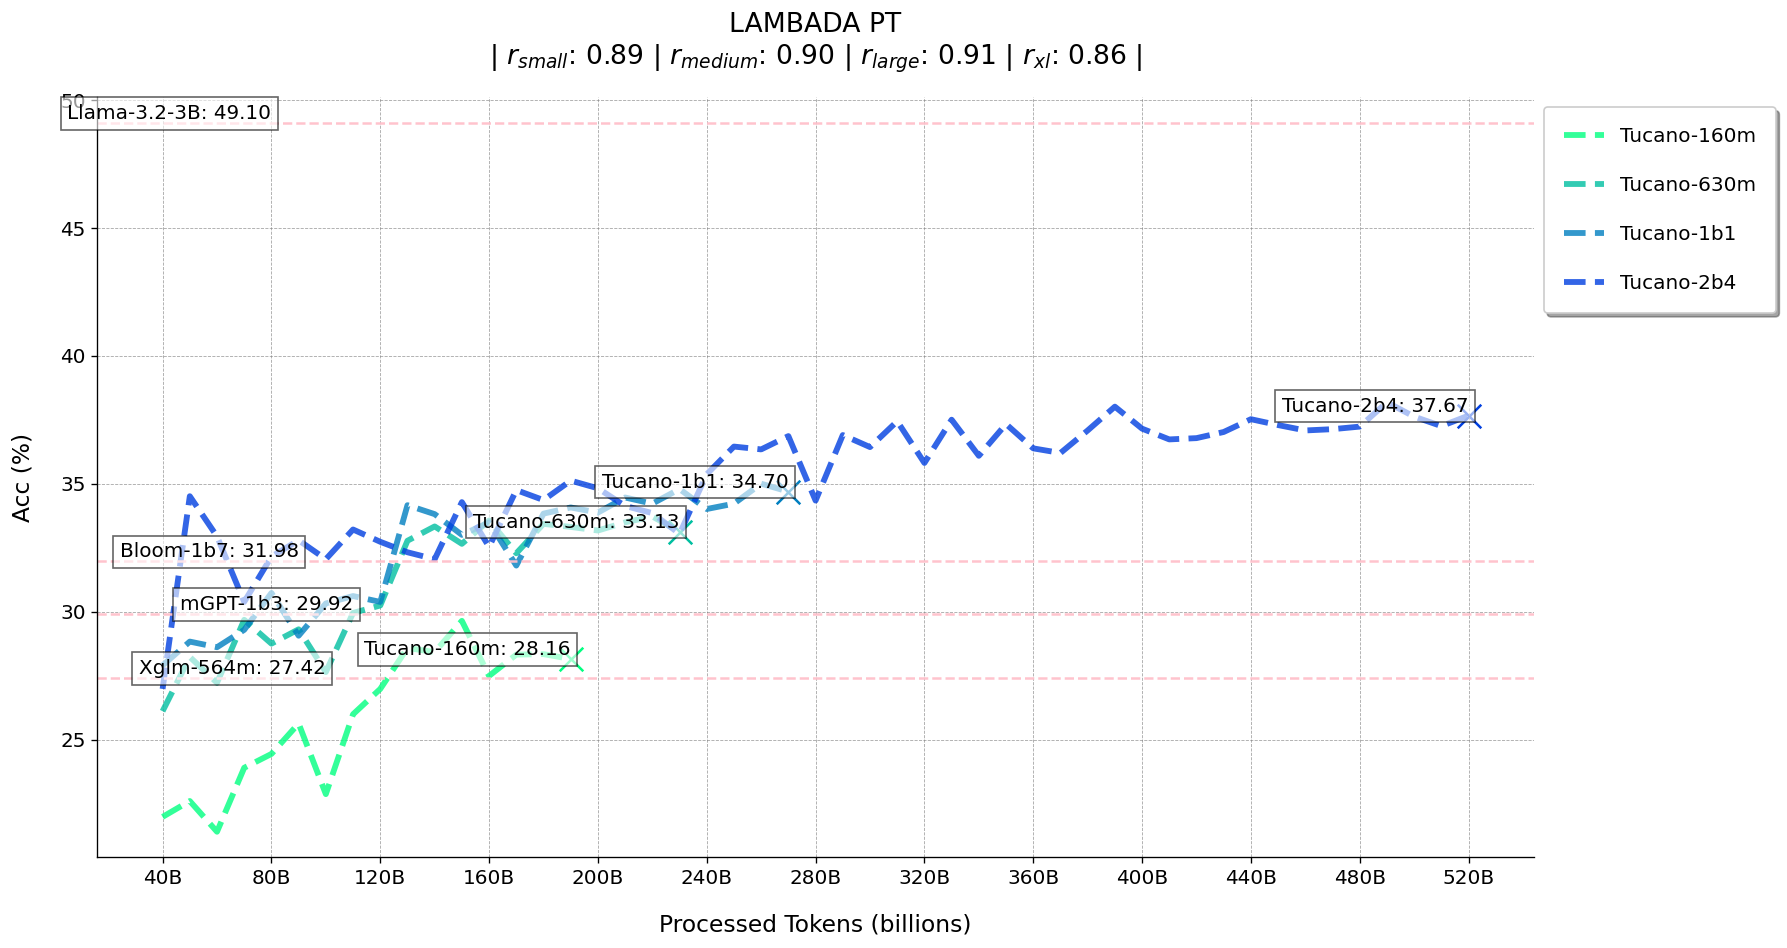

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

benchmarks_to_remove = [
        'enem', 
        'bluex', 
        'oab_exams', 
        'assin2_rte', 
        'assin2_sts',
        'faquad_nli', 
        'hatebr', 
        'hatespeech_pt', 
        'tweet_br', 
        #'calame_pt',
        #'arc_pt', 
        #'hellaswag_pt', 
        'truthfulqa', 
        #'lambada_pt'
    ]


df_small = pd.read_csv('./evals/EVALS-160m.csv')
df_small = df_small.drop(columns=benchmarks_to_remove)
df_medium = pd.read_csv('./evals/EVALS-630m.csv')
df_medium = df_medium.drop(columns=benchmarks_to_remove)
df_large = pd.read_csv('./evals/EVALS-1b1.csv')
df_large = df_large.drop(columns=benchmarks_to_remove)
df_xl = pd.read_csv('./evals/EVALS-2b4.csv')
df_xl = df_xl.drop(columns=benchmarks_to_remove)

# For the xl model, we need to manipulate the step column to match the other models,
# given that it was trained with a batch size half the size of the other models.
df_xl['step'] = [20000 * i for i in range(1, len(df_xl) + 1)]

cmap = plt.get_cmap('winter_r')
colors = [cmap(i / 4) for i in range(4)]
benchmarks = df_small.columns[1:]

for benchmark in benchmarks:
    temp_df_small = df_small[["step", benchmark]]
    temp_df_medium = df_medium[["step", benchmark]]
    temp_df_large = df_large[["step", benchmark]]
    temp_df_xl = df_xl[["step", benchmark]]

    steps = temp_df_xl.step.values
    scores_small = temp_df_small[benchmark].values
    scores_medium = temp_df_medium[benchmark].values
    scores_large = temp_df_large[benchmark].values
    scores_xl = temp_df_xl[benchmark].values

    plt.figure(figsize=(15, 8), dpi=120)

    plt.plot(steps[:len(scores_small)], scores_small, label='Tucano-160m', color=colors[0], linestyle='--', linewidth=3.5, alpha=0.8)
    plt.plot(steps[:len(scores_medium)], scores_medium, label='Tucano-630m', color=colors[1], linestyle='--', linewidth=3.5, alpha=0.8)
    plt.plot(steps[:len(scores_large)], scores_large, label='Tucano-1b1', color=colors[2], linestyle='--', linewidth=3.5, alpha=0.8)
    plt.plot(steps[:len(scores_xl)], scores_xl, label='Tucano-2b4', color=colors[3], linestyle='--', linewidth=3.5, alpha=0.8)

    plt.scatter(steps[:len(scores_small)][-1], scores_small[-1], color=colors[0], marker='x', s=200)
    plt.scatter(steps[:len(scores_medium)][-1], scores_medium[-1], color=colors[1], marker='x', s=200)
    plt.scatter(steps[:len(scores_large)][-1], scores_large[-1], color=colors[2], marker='x', s=200)
    plt.scatter(steps[:len(scores_xl)][-1], scores_xl[-1], color=colors[3], marker='x', s=200)

    plt.text(steps[:len(scores_small)][-1], scores_small[-1], f'Tucano-160m: {scores_small[-1]:.2f}', ha='right', va='bottom', 
                fontsize=12, color="black", backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6))
    plt.text(steps[:len(scores_medium)][-1], scores_medium[-1], f'Tucano-630m: {scores_medium[-1]:.2f}', ha='right', va='bottom', 
                fontsize=12, color="black", backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6))
    plt.text(steps[:len(scores_large)][-1], scores_large[-1], f'Tucano-1b1: {scores_large[-1]:.2f}', ha='right', va='bottom', 
                fontsize=12, color="black", backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6))
    plt.text(steps[:len(scores_xl)][-1], scores_xl[-1], f'Tucano-2b4: {scores_xl[-1]:.2f}', ha='right', va='bottom',
                fontsize=12, color="black", backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6))
    
    # Reference model scores for comparisons
    if benchmark == 'enem':
        model_scores = {
            #'Llama-3.2-3B': 53.04,
            'Llama-3.2-1B': 23.37,
            #'Tucano-2b4': 20.5,
            #'Tucano-1b1': 21.41,
            #'Tucano-630m': 19.17,
            'Bloom-1b1': 19.87,
            #'Bloom-1b7': 18.96,
            #'Xglm-564m': 19.03,
            #'TTL-460m': 20.15,
            #'TTL-160m': 19.24,
            #'Tucano-160m': 19.03,
            #'Bloom-560m': 19.03,
            #'GPorTuguese': 19.31,
            'mGPT-1b3': 16.66,
            'GlórIA-1b3': 1.89
        }
    
    elif benchmark == 'bluex':
        model_scores = {
            'Llama-3.2-3B': 50.35,
            #'Llama-3.2-1B': 24.2,
            #'Tucano-2b4': 23.23,
            #'Tucano-1b1': 23.37,
            #'Tucano-630m': 24.76,
            #'Bloom-1b1': 22.11,
            #'Bloom-1b7': 21.42,
            #'Xglm-564m': 19.75,
            #'TTL-460m': 25.73,
            #'TTL-160m': 23.09,
            #'Tucano-160m': 22.11,
            'Bloom-560m': 18.92,
            #'GPorTuguese': 21.42,
            'mGPT-1b3': 10.43,
            'GlórIA-1b3': 3.2
        }

    elif benchmark == 'oab_exams':
        model_scores = {
            'Llama-3.2-3B': 39.45,
            #'Llama-3.2-1B': 25.88,
            #'Tucano-2b4': 25.47,
            #'Tucano-1b1': 25.97,
            #'Tucano-630m': 25.28,
            #'Bloom-1b1': 24.74,
            #'Bloom-1b7': 23.05,
            'Xglm-564m': 23.55,
            #'TTL-460m': 27.02,
            #'TTL-160m': 22.37,
            #'Tucano-160m': 25.1,
            #'Bloom-560m': 23.05,
            'GPorTuguese': 3.14,
            'mGPT-1b3': 8.56,
            'GlórIA-1b3': 5.19
        }
    
    elif benchmark == 'assin2_rte':
        model_scores = {
            'Llama-3.2-3B': 83.64,
            #'Llama-3.2-1B': 50.77,
            #'Tucano-2b4': 56.27,
            #'Tucano-1b1': 60.82,
            #'Tucano-630m': 57.79,
            #'Bloom-1b1': 54.32,
            #'Bloom-1b7': 53.6,
            'Xglm-564m': 49.9,
            #'TTL-460m': 53.61,
            #'TTL-160m': 53.97,
            #'Tucano-160m': 33.51,
            'Bloom-560m': 33.33,
            #'GPorTuguese': 33.59,
            #'mGPT-1b3': 0,
            #'GlórIA-1b3': 0
        }
    
    elif benchmark == 'assin2_sts':
        model_scores = {
            'Llama-3.2-3B': 33.19,
            #'Llama-3.2-1B': 19.48,
            #'Tucano-2b4': 1.93,
            #'Tucano-1b1': 24.63,
            #'Tucano-630m': 1.99,
            #'Bloom-1b1': 14.64,
            #'Bloom-1b7': 4.81,
            #'Xglm-564m': 23.35,
            #'TTL-460m': 13,
            #'TTL-160m': 0.24,
            #'Tucano-160m': 11.02,
            'Bloom-560m': 8.48,
            'GPorTuguese': 3.44,
            #'mGPT-1b3': 0.58,
            'GlórIA-1b3': 2.32
        }

    elif benchmark == 'faquad_nli':
        model_scores = {
            #'Llama-3.2-3B': 43.97,
            #'Llama-3.2-1B': 43.97,
            #'Tucano-2b4': 43.97,
            #'Tucano-1b1': 43.97,
            #'Tucano-630m': 43.97,
            #'Bloom-1b1': 43.97,
            #'Bloom-1b7': 43.97,
            #'Xglm-564m': 43.97,
            #'TTL-460m': 46.41,
            #'TTL-160m': 43.97,
            #'Tucano-160m': 43.97,
            #'Bloom-560m': 43.97,
            #'GPorTuguese': 43.97,
            'mGPT-1b3': 0,
            'GlórIA-1b3': 0.26
        }

    elif benchmark == 'hatebr':
        model_scores = {
            'Llama-3.2-3B': 74.58,
            #'Llama-3.2-1B': 59.43,
            #'Tucano-2b4': 29.49,
            #'Tucano-1b1': 29,
            #'Tucano-630m': 53.73,
            #'Bloom-1b1': 38.45,
            #'Bloom-1b7': 34.89,
            #'Xglm-564m': 33.99,
            #'TTL-460m': 33.59,
            #'TTL-160m': 36.92,
            #'Tucano-160m': 36.56,
            #'Bloom-560m': 37.07,
            #'GPorTuguese': 33.33,
            'mGPT-1b3': 10.79,
            'GlórIA-1b3': 0.28
        }

    elif benchmark == 'hatespeech_pt':
        model_scores = {
            'Llama-3.2-3B': 41.99,
            #'Llama-3.2-1B': 38.57,
            #'Tucano-2b4': 41.98,
            #'Tucano-1b1': 41.19,
            #'Tucano-630m': 30.01,
            #'Bloom-1b1': 35.64,
            #'Bloom-1b7': 41.23,
            'Xglm-564m': 24.9,
            #'TTL-460m': 22.99,
            #'TTL-160m': 42.63,
            #'Tucano-160m': 22.99,
            #'Bloom-560m': 24.29,
            'GPorTuguese': 22.99,
            #'mGPT-1b3': 28.12,
            #'GlórIA-1b3': 23.52
        }
    
    elif benchmark == 'tweet_br':
        model_scores = {
            'Llama-3.2-3B': 61.43,
            #'Llama-3.2-1B': 42.34,
            #'Tucano-2b4': 58.0,
            #'Tucano-1b1': 32.18,
            #'Tucano-630m': 20.73,
            #'Bloom-1b1': 15.07,
            'Bloom-1b7': 15.07,
            #'Xglm-564m': 20.73,
            #'TTL-460m': 17.28,
            #'TTL-160m': 11.39,
            #'Tucano-160m': 16.86,
            #'Bloom-560m': 20.74,
            'GPorTuguese': 13.62,
            'mGPT-1b3': 11.36,
            #'GlórIA-1b3': 0.19
        }

    elif benchmark == 'calame_pt':
        model_scores = {
            'Llama-3.2-3B': 58.43,
            'Llama-3.2-1B': 51.83,
            #'Tucano-2b4': 59.06,
            #'Tucano-1b1': 58.24,
            #'Tucano-630m': 56.55,
            #'Bloom-1b1': 52.94,
            #'Bloom-1b7': 55.64,
            #'Xglm-564m': 50.58,
            #'TTL-460m': 49.42,
            #'TTL-160m': 46.72,
            #'Tucano-160m': 52.31,
            #'Bloom-560m': 49.95,
            #'GPorTuguese': 40.61,
            'mGPT-1b3': 47.14,
            'GlórIA-1b3': 52.79
        }

    elif benchmark == 'arc_pt':
        model_scores = {
            'Llama-3.2-3B': 43.25,
            #'Llama-3.2-1B': 33.5,
            #'Tucano-2b4': 30.43,
            #'Tucano-1b1': 30.43,
            #'Tucano-630m': 28.89,
            #'Bloom-1b1': 29.83,
            #'Bloom-1b7': 30.34,
            'Xglm-564m': 25.56,
            #'TTL-460m': 29.4,
            #'TTL-160m': 26.15,
            #'Tucano-160m': 27.01,
            'Bloom-560m': 24.74,
            #'GPorTuguese': 22.48,
            'mGPT-1b3': 23.81,
            #'GlórIA-1b3': 26.67
        }

    elif benchmark == 'hellaswag_pt':
        model_scores = {
            'Llama-3.2-3B': 57.2,
            #'Llama-3.2-1B': 45.44,
            #'Tucano-2b4': 47.17,
            #'Tucano-1b1': 42.84,
            #'Tucano-630m': 39.41,
            #'Bloom-1b1': 39.74,
            #'Bloom-1b7': 43.52,
            #'Xglm-564m': 34.64,
            #'TTL-460m': 33,
            #'TTL-160m': 29.29,
            #'Tucano-160m': 33.07,
            #'Bloom-560m': 37.15,
            'GPorTuguese': 29.62,
            'mGPT-1b3': 26.37,
            #'GlórIA-1b3': 37.04
        }

    elif benchmark == 'truthfulqa':
        model_scores = {
            'Llama-3.2-3B': 43.64,
            #'Llama-3.2-1B': 41.63,
            #'Tucano-2b4': 39.3,
            #'Tucano-1b1': 41.59,
            #'Tucano-630m': 42.76,
            #'Bloom-1b1': 41.04,
            #'Bloom-1b7': 41.86,
            #'Xglm-564m': 42.53,
            #'TTL-460m': 41.1,
            #'TTL-160m': 41.12,
            #'Tucano-160m': 41.53,
            #'Bloom-560m': 42.44,
            #'GPorTuguese': 41.44,
            #'mGPT-1b3': 39.62,
            #'GlórIA-1b3': 42.44
        }

    elif benchmark == 'lambada_pt':
        model_scores = {
            'Llama-3.2-3B': 49.1,
            #'Llama-3.2-1B': 41.02,
            #'Tucano-2b4': 37.67,
            #'Tucano-1b1': 34.7,
            #'Tucano-630m': 33.13,
            #'Bloom-1b1': 30.22,
            'Bloom-1b7': 31.98,
            'Xglm-564m': 27.42,
            #'TTL-460m': 23.29,
            #'TTL-160m': 20.98,
            #'Tucano-160m': 28.16,
            #'Bloom-560m': 25.44,
            #'GPorTuguese': 22.98,
            'mGPT-1b3': 29.92,
            #'GlórIA-1b3': 27.71
        }
    
    for i, (model, value) in enumerate(model_scores.items(), start=1):
        plt.axhline(y=value, color='pink', linestyle='--', alpha=0.95)
        plt.text(steps[i + 3], value, f'{model}: {value:.2f}', ha='right', va='bottom', 
                fontsize=12, color="black", backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6))
    
    steps = [step for i, step in enumerate(steps) if i % 4 == 0]
    custom_tick_labels = ['40B', '80B', '120B', '160B', '200B', '240B', '280B', '320B', '360B', 
        '400B', '440B', '480B', '520B'][:len(steps)]

    plt.xticks(steps, labels=custom_tick_labels, fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel('Processed Tokens (billions)', fontsize=14, labelpad=15)
    plt.ylabel('Acc (%)', fontsize=14, labelpad=15)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, frameon=True, fancybox=True, shadow=True, borderpad=1, labelspacing=1.5)
    
    all_scores = np.concatenate((scores_small, scores_medium, scores_large, scores_xl, np.array(list(model_scores.values()))))
    plt.ylim(min(all_scores) - 1, max(all_scores) + 1)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    correlation_small = np.corrcoef([10.5e9 * i for i in range(1, len(scores_small)+1)], scores_small)[0, 1]
    correlation_medium = np.corrcoef([10.5e9 * i for i in range(1, len(scores_medium)+1)], scores_medium)[0, 1]
    correlation_large = np.corrcoef([10.5e9 * i for i in range(1, len(scores_large)+1)], scores_large)[0, 1]
    correlation_xl = np.corrcoef([10.5e9 * i for i in range(1, len(scores_xl)+1)], scores_xl)[0, 1]

    plt.title(f"{benchmark.upper().replace('_', ' ')}\n| $r_{'{small}'}$: {correlation_small:.2f} | $r_{'{medium}'}$: {correlation_medium:.2f} | $r_{'{large}'}$: {correlation_large:.2f} | $r_{'{xl}'}$: {correlation_xl:.2f} |", fontsize=16, pad=20)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    plt.savefig(f'../img/evals-{benchmark}.png', format='png', dpi=300)
    plt.savefig(f'../img/evals-{benchmark}.svg', format='svg', dpi=300)
    plt.show()

- Plot the score distribution of the [GigaVerbo-Text-Filter](../cards/datasets/gigaverbo-text-filter.md).

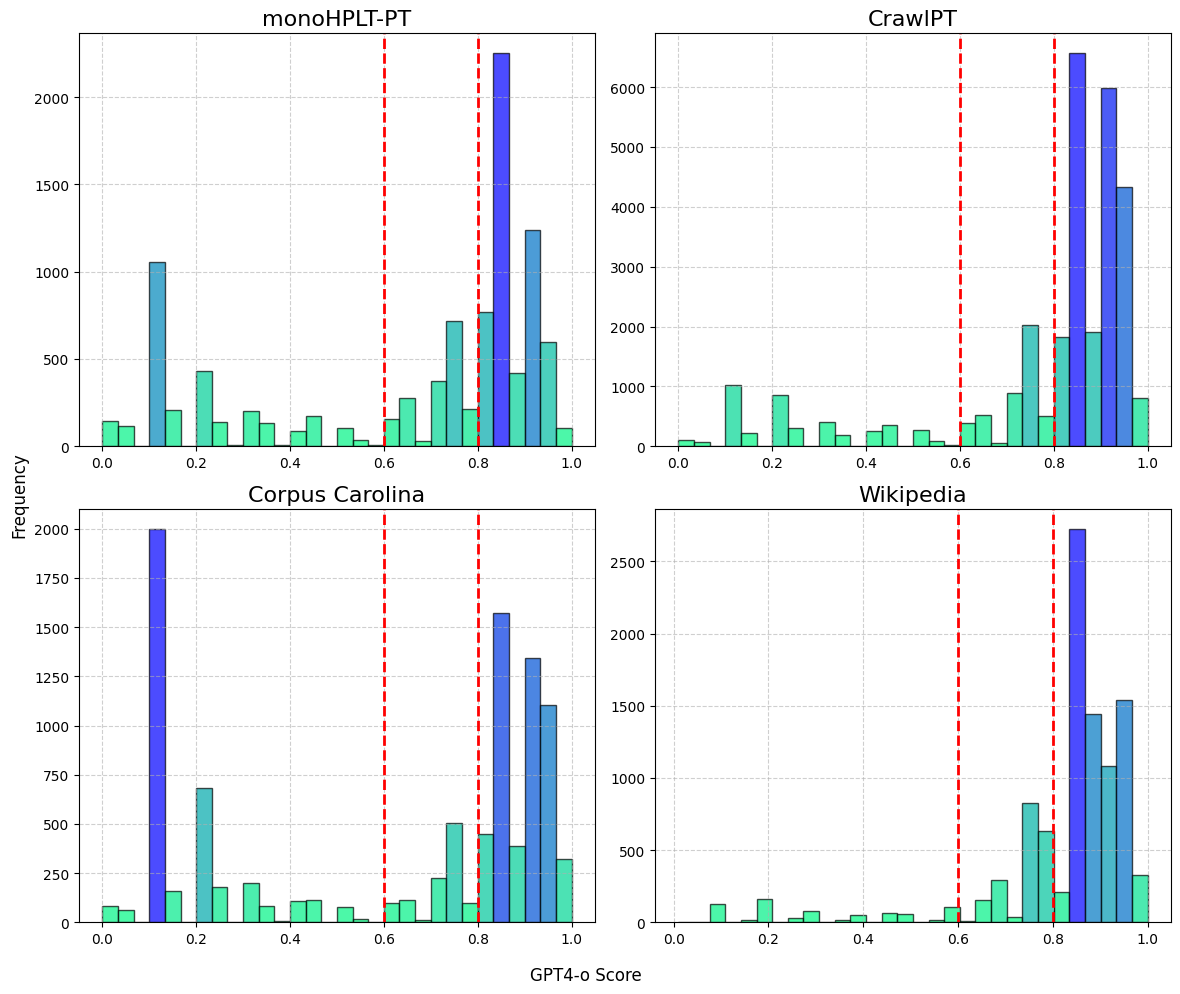

In [9]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

ds = load_dataset("TucanoBR/GigaVerbo-Text-Filter", split="train")
df = ds.to_pandas()

datasets = ['monoHPLT-PT', 'CrawlPT', 'Corpus Carolina', 'Wikipedia']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

cmap = plt.get_cmap('winter_r')

for i, dataset in enumerate(datasets):

    temp_df = df[df.dataset == dataset]
    counts, bins = np.histogram(temp_df.score.values, bins=30)
    norm = plt.Normalize(vmin=counts.min(), vmax=counts.max())
    colors = cmap(norm(counts))
    
    axes[i].bar(bins[:-1], counts, width=np.diff(bins), edgecolor='black', color=colors, alpha=0.7, align='edge')
    axes[i].set_title(f'{dataset}', fontsize=16)
    axes[i].grid(True, linestyle='--', alpha=0.6)
    axes[i].axvline(x=0.8, color='red', linestyle='--', linewidth=2)
    axes[i].axvline(x=0.6, color='red', linestyle='--', linewidth=2)

fig.supxlabel('GPT4-o Score', fontsize=12)
fig.supylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.savefig("../img/scores-classification-dataset.png", dpi=300, transparent=True)
plt.savefig("../img/scores-classification-dataset.svg", format="svg", transparent=True)
plt.show()


- Plot gradient accumulation experiments.

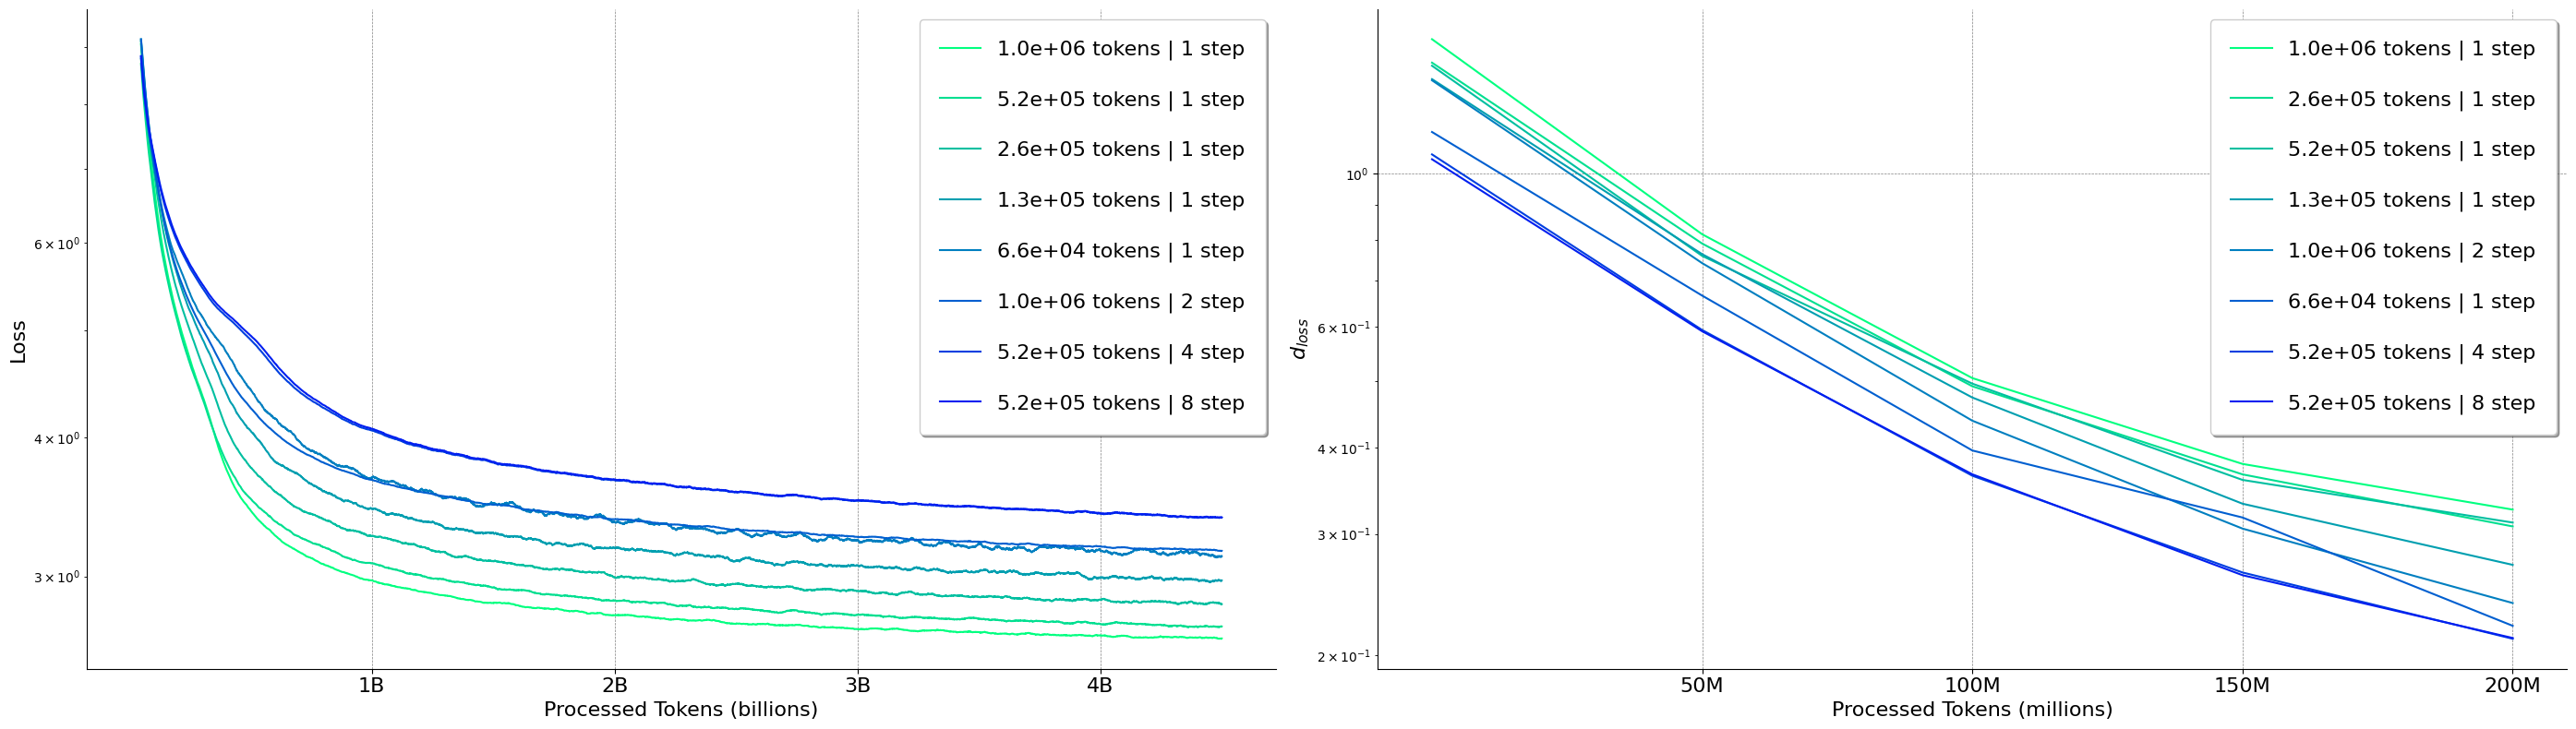

In [12]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("./evals/gradient-accumulation-experiments.csv")
df.columns = [
 '5.2e+05 tokens | 1 step',
 '1.0e+06 tokens | 2 step',
 '1.3e+05 tokens | 1 step',
 '1.0e+06 tokens | 1 step',
 '5.2e+05 tokens | 4 step',
 '2.6e+05 tokens | 1 step',
 '6.6e+04 tokens | 1 step',
 '5.2e+05 tokens | 8 step'
]

smoothed_df = df.copy()
for column in df.columns:
    smoothed_df[column] = df[column].rolling(window=100).mean()

smoothed_df = smoothed_df.dropna()

cmap = plt.get_cmap('winter_r')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 8))
sorted_columns = smoothed_df.columns[np.argsort(smoothed_df.iloc[-1])]
num_lines = len(sorted_columns)

for i, column in enumerate(sorted_columns):
    ax1.plot(smoothed_df[column], label=column, color=cmap(i / num_lines))

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(color='gray', linestyle='--', linewidth=0.5)
ax1.set_yscale('log')

custom_ticks = [2000, 4000, 6000, 8000]  
custom_tick_labels = ['1B', '2B', '3B', '4B']

ax1.set_xticks(custom_ticks, fontsize=16)
ax1.set_xticklabels(custom_tick_labels, fontsize=16)

ax1.legend(fontsize='16', loc='upper right', 
           frameon=True, fancybox=True, shadow=True, borderpad=1, labelspacing=1.5)

ax1.set_xlabel('Processed Tokens (billions)', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.grid(True)

d_loss = pd.DataFrame()

for column in smoothed_df.columns:
    d_loss[column] = np.array([np.mean(smoothed_df[column].iloc[i*100:(i+1)*100])-np.mean(smoothed_df[column].iloc[(i+1)*100:(i+2)*100]) for i in range(len(smoothed_df[column])//100-2)])

sorted_columns = d_loss.columns[np.argsort(d_loss.iloc[0])]
sorted_columns = sorted_columns[::-1]
num_lines = len(sorted_columns)

for i, column in enumerate(sorted_columns):
    ax2.plot(d_loss[column][:5], label=column, color=cmap(i / num_lines))

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(color='gray', linestyle='--', linewidth=0.5)
ax2.set_yscale('log')

custom_ticks = [1, 2, 3, 4]  
custom_tick_labels = ['50M', '100M', '150M', '200M']

ax2.set_xticks(custom_ticks, fontsize=16)
ax2.set_xticklabels(custom_tick_labels, fontsize=16)

ax2.legend(fontsize='16', loc='upper right', 
           frameon=True, fancybox=True, shadow=True, borderpad=1, labelspacing=1.5)

ax2.set_xlabel('Processed Tokens (millions)', fontsize=16)
ax2.set_ylabel(r'$d_{loss}$', fontsize=16)
ax2.grid(True)

plt.tight_layout()
plt.savefig("../img/ga-experiments.png", dpi=300, transparent=True)
plt.savefig("../img/ga-experiments.svg", format="svg", transparent=True)
plt.show()


- Perform the tokenizer evaluation. The [tokenizer-test-set.txt](./tokenizer-test-set.txt) contains $\approx$ 14,000 words from Portuguese poems extracted from authors like Fernando Pessoa and Ronald de Carvalho, among others.

In [ ]:
from transformers import AutoTokenizer

with open("./evals/tokenizer-test-set.txt", "r") as file:
    text = "".join(file.readlines())

print("Lenght in words of the sample text: ", len(text.split()))

token=None

tokenizers = [
    "TucanoBR/Tucano-1b1",
    "neuralmind/bert-base-portuguese-cased",
    "pablocosta/bertabaporu-base-uncased",
    "sagui-nlp/debertinha-ptbr-xsmall",
    "pierreguillou/gpt2-small-portuguese",
    "NOVA-vision-language/GlorIA-1.3B",
    "PORTULAN/gervasio-7b-portuguese-ptbr-decoder",
    "PORTULAN/gervasio-7b-portuguese-ptpt-decoder",
    "PORTULAN/albertina-100m-portuguese-ptbr-encoder",
    "PORTULAN/albertina-100m-portuguese-ptpt-encoder",
    "unicamp-dl/ptt5-base-portuguese-vocab",
    "eduagarcia/RoBERTaCrawlPT-base",
    "eduagarcia/RoBERTaLexPT-base",
    "raquelsilveira/legalbertpt_sc",
    "22h/open-cabrita3b",
    "maritaca-ai/sabia-7b",
    "maritaca-ai/sabia-2-tokenizer-medium",
    "recogna-nlp/bode-7b-alpaca-pt-br-no-peft",
    "ai-forever/mGPT",
    "google-bert/bert-base-multilingual-cased",
    "bigscience/bloom",
    "facebook/xglm-564M",
    "dice-research/lola_v1"
    "DAMO-NLP-MT/polylm-1.7b",
    "botbot-ai/CabraLlama3-8b",
    "FacebookAI/xlm-roberta-base",
    "google/mt5-base",
    "unicamp-dl/ptt5-large-portuguese-vocab",
    "ibm-granite/granite-3.0-8b-base"
]

table = """| Tokenizer | Number of tokens | Vocabulary size |\n| --- | --- | --- |"""

for tokenizer_name in tokenizers:
    name = tokenizer_name.split('/')[-1]

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, token=token, use_fast=True)
    tokens = tokenizer(text)

    table += f"\n| {name} | {len(tokens['input_ids'])} | {len(tokenizer.get_vocab())} |"

print(table)



| Tokenizer        | Number of tokens | Vocabulary size |
|------------------|------------------|-----------------|
| BERTabaporu      | 22764            | 64000           |
| Bloom            | 24117            | 250680          |
| TeenyTinyLlama   | 25263            | 32000           |
| XGLM             | 25454            | 256008          |
| XLM              | 26078            | 250002          |
| RoBERTa Crawl    | 26300            | 50265           |
| RoBERTa Lex      | 26382            | 50265           |
| LegalBert-pt     | 26559            | 36345           |
| BERTimbau        | 26777            | 29794           |
| GlórIA           | 27064            | 50258           |
| GPorTuguese-2    | 27190            | 50257           |
| PTT5             | 27958            | 32100           |
| DeBERTinha       | 28143            | 50270           |
| mBERT            | 28162            | 119547          |
| PolyLM           | 28620            | 256000          |
| Llama3    

- Plot the results of the tokenizer evaluation.

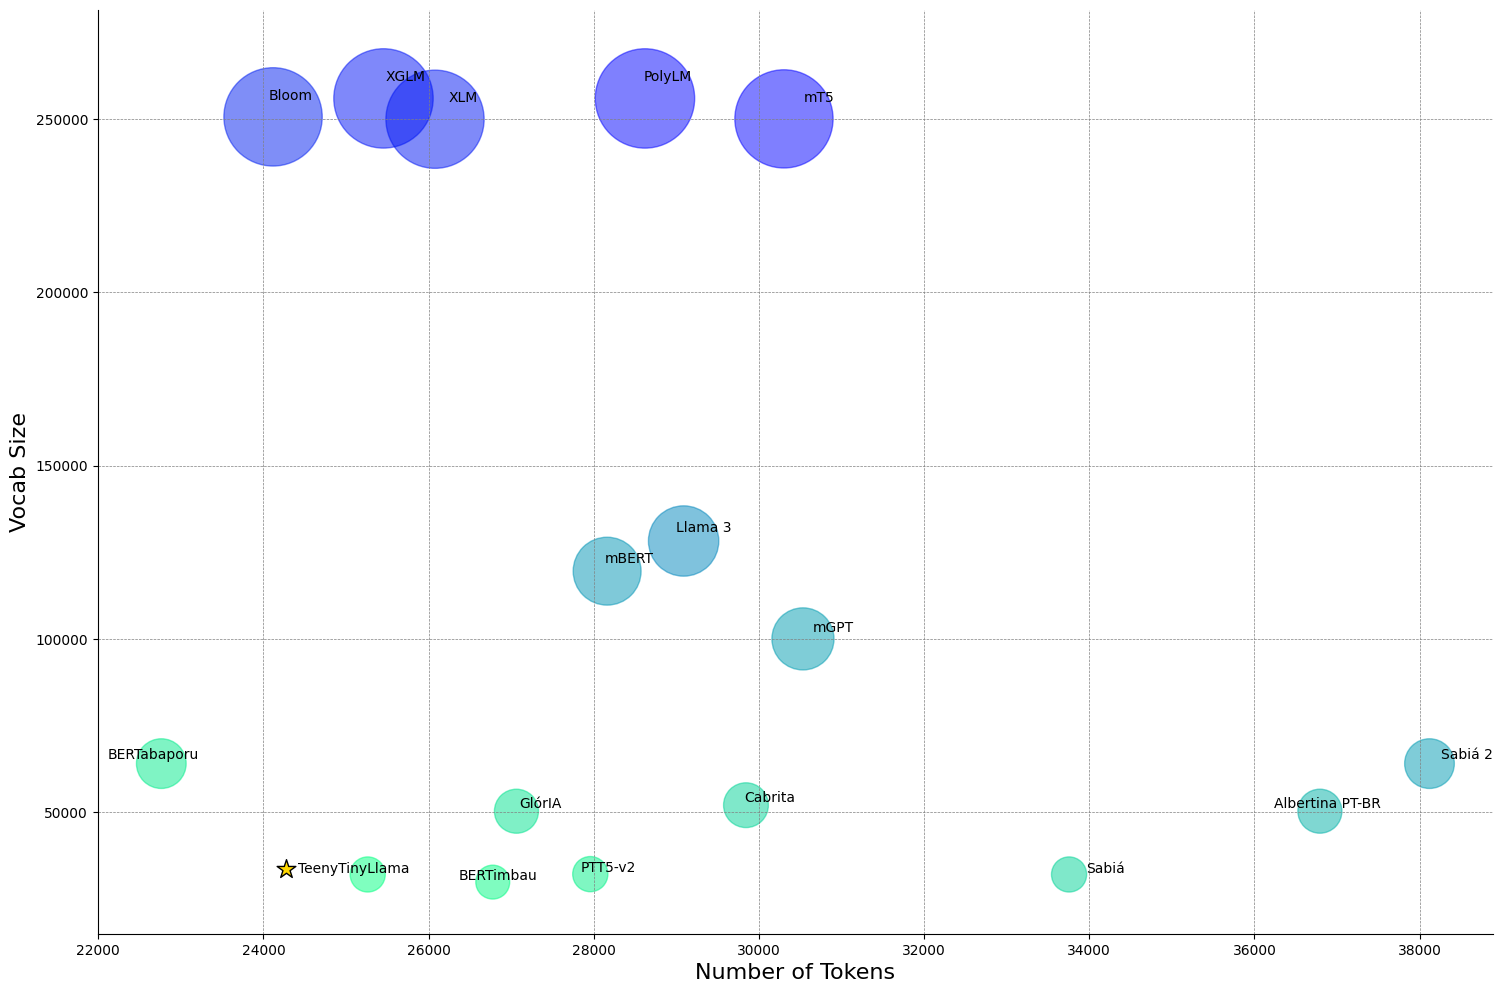

In [5]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

tokenizer = [
    "BERTabaporu", "Bloom", "TeenyTinyLlama", "XGLM", "XLM", "BERTimbau", 
    "GlórIA", "PTT5-v2", "mBERT", "PolyLM", "Llama 3", "Cabrita", 
    "mT5", "mGPT", "Sabiá", "Albertina PT-BR", "Sabiá 2"
]

n_of_tokens = [
    22764, 24117, 25263, 25454, 26078, 26777, 27064, 27958, 28162, 
    28620, 29088, 29843, 30303, 30533, 33755, 36792, 38119
]

vocab_size = [
    64000, 250680, 32000, 256008, 250002, 29794, 50258, 32100, 119547, 
    256000, 128256, 52000, 250100, 100000, 32000, 50265, 64000
]

combined_metric = 0.99 * np.array(n_of_tokens) + 0.2 * np.array(vocab_size)
cmap = plt.get_cmap('winter_r')
norm = plt.Normalize(vmin=min(combined_metric), vmax=max(combined_metric))

plt.figure(figsize=(18, 12))

plt.scatter(n_of_tokens, vocab_size, 
            s=[v / 50 for v in vocab_size], 
            c=combined_metric, 
            cmap=cmap, 
            norm=norm, 
            alpha=0.5, 
            marker='o')

for i, t in enumerate(tokenizer):
    plt.text(n_of_tokens[i] * 1.02, vocab_size[i] * 1.02, t, fontsize=10, ha='right')

index = tokenizer.index("TeenyTinyLlama")

x_tiny = n_of_tokens[index]
y_tiny = vocab_size[index]

plt.scatter(x_tiny * 0.961, y_tiny * 1.05, 
            s=200, 
            c='gold', 
            marker='*', 
            edgecolor='black')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim(min(vocab_size) / 2, max(vocab_size) * 1.1) 

ax.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('Number of Tokens', fontsize=16)
plt.ylabel('Vocab Size', fontsize=16)

plt.savefig("../img/tokenizer-comparison.png", dpi=300, transparent=True)
plt.savefig("../img/tokenizer-comparison.svg", format="svg", transparent=True)

plt.show()

## How do we interpret the output data from CodeCarbon?

After [significant investigation](https://github.com/mlco2/codecarbon/issues/544), we found out we need to:

- Get the measured `cpu_energy`, `gpu_energy`, and `ram_energy`.
We need to multiply `cpu_energy`, `gpu_energy`, and `ram_energy` by the number of nodes used (tracking apparently only works on single-node operations).

- To get the value from `gpu_energy`, you can multiply the medium wattage of all GPUS (W&B and the `nvidia-smi` can give you that, besides the logs from CodeCarbon) by the duration (in hours), and divide everything by 1000 to get kWh, i.e., `(duration * (wattage * n_gpus)) / 1000`.

- Hence, `energy_consumed` is acctualy `(cpu_energy + gpu_energy + ram_energy) * number_of_nodes`.
To get emissions, multiply the energy consumed (`energy_consumed * number_of_nodes`) by the carbon intensity of your current energy grid (e.g., Germany is 0.37 KgCO2.eq/KWh).

In [17]:
import pandas as pd
pd.set_option('display.max_columns', None)

# Paths for the data
emission_paths = {
    '160m': "./emissions/emissions-160m.csv", # 2 nodes (A100)
    '630m': "./emissions/emissions-630m.csv", # 2 nodes (A100)
    '1b1': "./emissions/emissions-1b1.csv", # 4 nodes (A100)
    '1b1-Instruct': "./emissions/emissions-1b1-instruct.csv", # (2 nodes sft, 1 node dpo) (A40)
    '2b4': "./emissions/emissions-2b4.csv", # 4 nodes (A100)
    '2b4-Instruct': "./emissions/emissions-2b4-instruct.csv" # (4 nodes sft, 1 node dpo) nodes (A100)
}
model = '1b1-Instruct'
number_of_nodes = 2
carbon_intensity = 0.37

df = pd.read_csv(emission_paths[model])


if "Instruct" not in model:

    energy_consumed = 0
    emissions = 0
    duration = 0

    for run_id in df.run_id.unique():

        df_run = df[df.run_id == run_id]
        duration += df_run.iloc[-1]['duration']
        energy_consumed += df_run.iloc[-1]['energy_consumed']
        emissions += df_run.iloc[-1]['emissions']

    energy_consumed = energy_consumed * number_of_nodes
    emissions = emissions * number_of_nodes
    duration = duration / 3600

    print(f"Duration: {duration:.2f} hours")
    print(f"Energy consumed: {energy_consumed:.2f} kWh")
    print(f"CO2 emitted: {emissions:.2f} KgCO2eq")

else:

    energy_consumed_sft = 0
    emissions_sft = 0
    duration_sft = 0

    energy_consumed_dpo = 0
    emissions_dpo = 0
    duration_dpo = 0

    for project_name in df.project_name.unique():
        if "sft" in project_name:
            df_run = df[df.project_name == project_name]
            duration_sft += df_run.iloc[-1]['duration']
            energy_consumed_sft += df_run.iloc[-1]['energy_consumed']
            emissions_sft += df_run.iloc[-1]['emissions']
            number_of_nodes_sft = df_run['n_nodes'].values[0]
        else:
            df_run = df[df.project_name == project_name]
            duration_dpo += df_run.iloc[-1]['duration']
            energy_consumed_dpo += df_run.iloc[-1]['energy_consumed']
            emissions_dpo += df_run.iloc[-1]['emissions']
            number_of_nodes_dpo = df_run['n_nodes'].values[0]
    
    energy_consumed_sft = energy_consumed_sft * number_of_nodes_sft
    emissions_sft = emissions_sft * number_of_nodes_sft
    duration_sft = duration_sft / 3600

    energy_consumed_dpo = energy_consumed_dpo * number_of_nodes_dpo
    emissions_dpo = emissions_dpo * number_of_nodes_dpo
    duration_dpo = duration_dpo / 3600

    energy_consumed = energy_consumed_sft + energy_consumed_dpo
    emissions = emissions_sft + emissions_dpo
    duration = duration_sft + duration_dpo

    print(f"Duration SFT: {duration_sft:.2f} hours")
    print(f"Energy consumed SFT: {energy_consumed_sft:.2f} kWh")
    print(f"CO2 emitted SFT: {emissions_sft:.2f} KgCO2eq")
    print("-" * 10)
    print(f"Duration DPO: {duration_dpo:.2f} hours")
    print(f"Energy consumed DPO: {energy_consumed_dpo:.2f} kWh")
    print(f"CO2 emitted DPO: {emissions_dpo:.2f} KgCO2eq")
    print("-" * 10)
    print(f"Total Duration: {duration:.2f} hours")
    print(f"Total Energy consumed: {energy_consumed:.2f} kWh")
    print(f"Total CO2 emitted: {emissions:.2f} KgCO2eq")

        

Duration SFT: 10.17 hours
Energy consumed SFT: 53.23 kWh
CO2 emitted SFT: 20.28 KgCO2eq
----------
Duration DPO: 1.77 hours
Energy consumed DPO: 4.23 kWh
CO2 emitted DPO: 1.61 KgCO2eq
----------
Total Duration: 11.94 hours
Total Energy consumed: 57.46 kWh
Total CO2 emitted: 21.89 KgCO2eq
